## Installing Required Libraries
Installing libraries used throughout the program using PIP

In [1]:
!pip install numpy pandas matplotlib scikit-learn qiskit==0.45.1 qiskit-machine-learning qiskit-algorithms==0.2.1

## **Importing Modules**
Installing modules used throughout the program

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings

# Classical models
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Analysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Feature Analysis
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes

from qiskit_algorithms.optimizers import COBYLA

# This defines where to train our classifier: on a simulator or a real quantum computer
from qiskit.primitives import Sampler                             # here we have chosen a simulator

from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

## **Data Loading**

Using dataset provided by <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud" style="color: #40E0D0;">Kaggle</a>

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


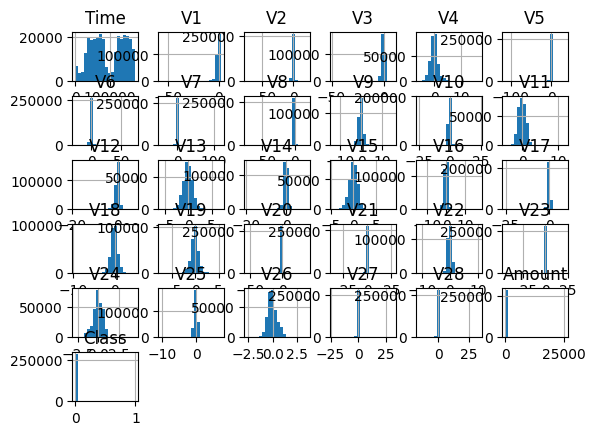

In [4]:
dataset_path = "creditcard.csv"

data = pd.read_csv(dataset_path)
histogram = data.hist(bins=20)

data

### <span style="color: #40E0D0;">Visualizing Loaded Data</span>

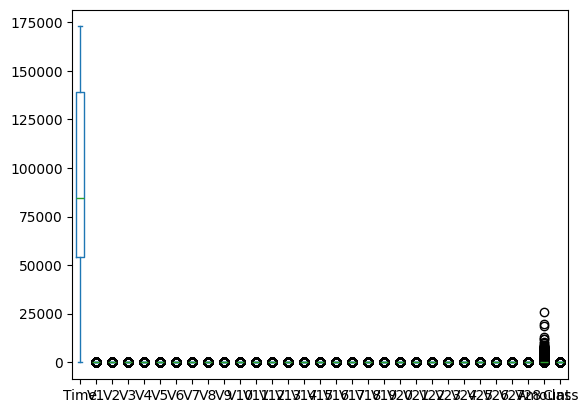

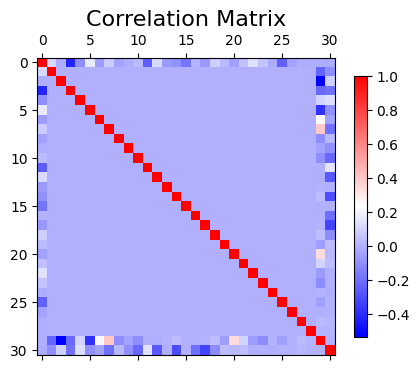

In [5]:
# 'Time' and 'Amount' are bigger than other features V1, ..., V28 values
data.plot.box()


# features V1, ..., V28 are not correlated as they are the principal components obtained with PCA
plt.matshow(data.corr(), cmap='bwr')
cb = plt.colorbar(shrink=0.7)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### <span style="color: #40E0D0;">1. Separating Normal and Fraud Cases</span>

In [6]:
normal = data[data.Class==0] # Set of all normal (y = 0) cases
fraud = data[data.Class==1]  # Set of all fraud (y = 1) cases


num_normal = normal.shape[0]
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 284315
Number of fraud examples = 492

normal to fraud ratio in the whole data = 577.88


### <span style="color: #40E0D0;">2. Sample Building by Choosing a Normal Fraud Ratio</span>

In [7]:
# A choice of normal_fraud_ratio has effects on precision and recall given below.

normal_fraud_ratio = 1                                      # normal_fraud_ratio = 1 means balance sample
normal_sample = normal.sample(normal_fraud_ratio*num_fraud)

# Joining row-wise (axis=0) normal and fraud cases to get a sample
sample = pd.concat([fraud, normal_sample], axis=0)

for i in range(100):
    sample = np.random.permutation(sample)                   # Random shuffling of sample examples 100 times

X, y = sample[:, :-1], sample[:, -1]

X = MinMaxScaler().fit_transform(X)            # This will put all the feature (X) values in the interval [0,1]

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)

X[:3,:], y[:3]                                 # Refer first 3 examples

number of examples =  984
number of features =  30


(array([[0.74384174, 0.95768553, 0.31975867, 0.77251932, 0.43468251,
         0.65323246, 0.43819727, 0.72923404, 0.68365963, 0.73661519,
         0.66270051, 0.433567  , 0.7258133 , 0.41549868, 0.46983228,
         0.41377163, 0.6799062 , 0.70795577, 0.72175331, 0.42424708,
         0.30115901, 0.46768452, 0.54966047, 0.76868037, 0.75444591,
         0.76459412, 0.26053873, 0.76737872, 0.61437137, 0.02484231],
        [0.83453856, 0.90604866, 0.27670649, 0.92193673, 0.07865609,
         0.6542988 , 0.4846152 , 0.770497  , 0.68201882, 0.6919346 ,
         0.80271984, 0.21715564, 0.85198407, 0.34505024, 0.85734474,
         0.46467762, 0.90523231, 0.78696424, 0.66166922, 0.42995549,
         0.26928002, 0.46373531, 0.55775656, 0.77622345, 0.8726355 ,
         0.67136055, 0.24181441, 0.70059233, 0.54382007, 0.01756158],
        [0.29965092, 0.94383774, 0.21737773, 0.87732336, 0.15205039,
         0.63862138, 0.42788392, 0.78483065, 0.66817633, 0.83319205,
         0.77564397, 0.25049619,

In [8]:
'''
Zero padding is to make the number of features equal to a power of 2.
It is required for 'amplitude encoding' given below.
'''

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (5, 32)
number of examples =  984
number of features =  32


### <span style="color: #40E0D0;">3. Train-Test Split</span>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)

(688, 32) (296, 32)


## **Quantum Machine Learning**

Use either angle or amplitude feature encoding </br>
__When the number of features is large (say, more than 6), use amplitude encoding__

### <span style="color: #40E0D0;">1a. Feature Map (FM): Angle Encoding</span>

In [10]:
fm = ZZFeatureMap(feature_dimension=num_features, reps=1)                   # ZZFeatureMap is more suited
fm.decompose().draw()

┌───┐┌─────────────┐                                                »
 q_0: ┤ H ├┤ P(2.0*x[0]) ├───■────────────────────────────────────■────■──»
      ├───┤├─────────────┤ ┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
 q_1: ┤ H ├┤ P(2.0*x[1]) ├─┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
      ├───┤├─────────────┤ └───┘└──────────────────────────────┘└───┘┌─┴─┐»
 q_2: ┤ H ├┤ P(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
      ├───┤├─────────────┤                                           └───┘»
 q_3: ┤ H ├┤ P(2.0*x[3]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_4: ┤ H ├┤ P(2.0*x[4]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_5: ┤ H ├┤ P(2.0*x[5]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_6: ┤ H ├┤ P(2.0*x[6]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_7: ┤ H ├┤ P(2.0*x[7]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_8: ┤ H ├┤ P(2.0*x[8]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_9: ┤ H ├┤ P(2.0*x[9]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┴┐                                               »
q_10: ┤ H ├┤ P(2.0*x[10]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_11: ┤ H ├┤ P(2.0*x[11]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_12: ┤ H ├┤ P(2.0*x[12]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_13: ┤ H ├┤ P(2.0*x[13]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_14: ┤ H ├┤ P(2.0*x[14]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_15: ┤ H ├┤ P(2.0*x[15]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_16: ┤ H ├┤ P(2.0*x[16]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_17: ┤ H ├┤ P(2.0*x[17]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_18: ┤ H ├┤ P(2.0*x[18]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_19: ┤ H ├┤ P(2.0*x[19]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_20: ┤ H ├┤ P(2.0*x[20]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_21: ┤ H ├┤ P(2.0*x[21]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_22: ┤ H ├┤ P(2.0*x[22]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_23: ┤ H ├┤ P(2.0*x[23]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_24: ┤ H ├┤ P(2.0*x[24]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_25: ┤ H ├┤ P(2.0*x[25]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                           

### <span style="color: #40E0D0;">1b. Feature Map (FM): Amplitude Encoding</span>

__Zero padding given above is needed for this encoding__

In [11]:
fm = RawFeatureVector(feature_dimension=num_features)
fm.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_1: ┤1                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_2: ┤2 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31]) ├
«     │                                                                                                                                                                                                                 │
«q_3: ┤3                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_4: ┤4                                                                                                                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### <span style="color: #40E0D0;">2. Parameterized Quantum Circuit (PQC)</span>

In [12]:
'''
For angle encoding, num_qubits = num_features
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps=3)
pqc.decompose().draw()

┌──────────┐                                          ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────────────────────────────■───────┤ Ry(θ[5]) ├»
     ├──────────┤                                ┌─┴─┐     ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──────────────────────■─────────┤ X ├─────┤ Ry(θ[6]) ├»
     ├──────────┤                    ┌─┴─┐    ┌──┴───┴───┐ └──────────┘»
q_2: ┤ Ry(θ[2]) ├──────────■─────────┤ X ├────┤ Ry(θ[7]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_3: ┤ Ry(θ[3]) ├──■─────┤ X ├────┤ Ry(θ[8]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_4: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[9]) ├───────────────┤ X ├────┤ Ry(θ[14]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                               ┌───────────┐                          »
«q_0: ───────────────────■──────┤ Ry(θ[10]) ├───────────────────■──────»
«                      ┌─┴─┐    ├───────────┤                 ┌─┴─┐    »
«q_1: ──────■──────────┤ X ├────┤ Ry(θ[11]) ├──────■──────────┤ X ├────»
«         ┌─┴─┐    ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐»
«q_2: ────┤ X ├────┤ Ry(θ[12]) ├──────■──────────┤ X ├────┤ Ry(θ[17]) ├»
«     ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘»
«q_3: ┤ Ry(θ[13]) ├──────■──────────┤ X ├────┤ Ry(θ[18]) ├─────────────»
«     └───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘             »
«q_4: ─────────────────┤ X ├────┤ Ry(θ[19]) ├──────────────────────────»
«                      └───┘    └───────────┘                          »
«     ┌───────────┐
«q_0: ┤ Ry(θ[15]) ├
«     ├───────────┤
«q_1: ┤ Ry(θ[16]) ├
«     └───────────┘
«q_2: ─────────────
«                  
«q_3: ─────────────
«                  
«q_4: ─────────────
«

### <span style="color: #40E0D0;">3. Build the Model: [Variational Quantum Classifier (VQC)](https://qiskit.org/documentation/stable/0.19/stubs/qiskit.aqua.algorithms.VQC.html#qiskit.aqua.algorithms.VQC) with FM and PQC</span>




In [13]:
# A callback that can access the intermediate data during the optimization
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

optimizer = COBYLA(maxiter=150)                 # maxiter = Maximum number of iterations (function evaluations)
sampler = Sampler()

objective_func_vals = []

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

### <span style="color: #40E0D0;">4. Training VQC</span>

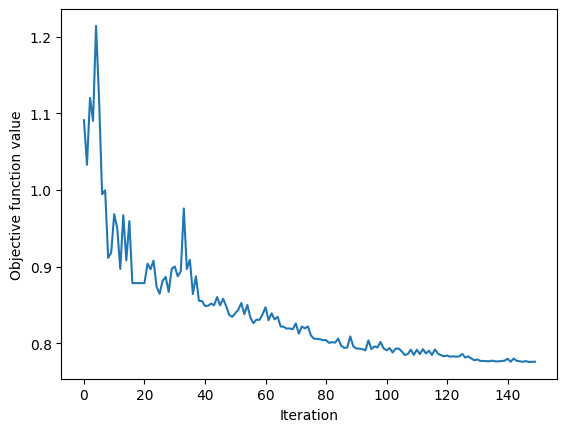

CPU times: user 10min 17s, sys: 16.9 s, total: 10min 34s
Wall time: 10min 25s


In [14]:
%%time

'''Training time seems to increase with the number of features'''

vqc.fit(X_train, y_train)

### <span style="color: #40E0D0;">5. Performance Evaluation of Trained VQC</span>




In [17]:
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       338
         1.0       1.00      0.78      0.88       350

    accuracy                           0.89       688
   macro avg       0.91      0.89      0.89       688
weighted avg       0.91      0.89      0.89       688

[[338   0]
 [ 76 274]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       154
         1.0       1.00      0.70      0.83       142

    accuracy                           0.86       296
   macro avg       0.89      0.85      0.85       296
weighted avg       0.89      0.86      0.85       296

[[154   0]
 [ 42 100]] = confusion matrix for test set 
 
0.85 = roc_auc_score for test set 



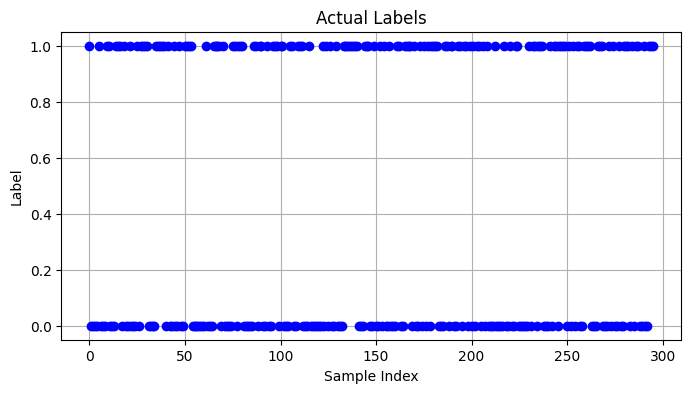

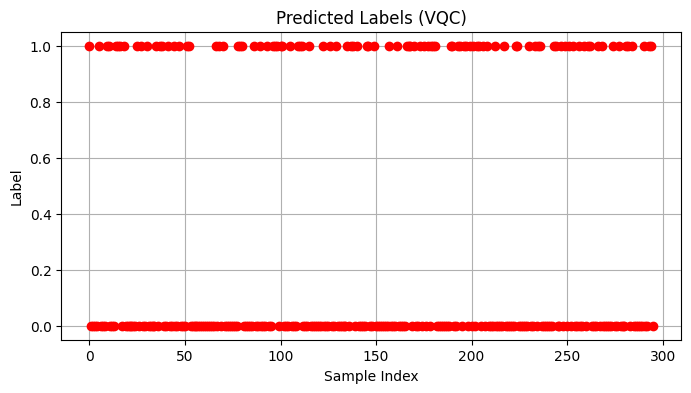

In [21]:
# Get predictions
result = vqc.predict(X_test)
y_pred = result  # adjust this if your result object has a .labels or .predicted_labels field

import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test (true labels) and y_pred (predicted outputs) are defined
# If y_pred is continuous, apply rounding or thresholding
y_pred_binary = np.round(y_pred)

# Plot actual labels
plt.figure(figsize=(8, 4))
plt.plot(range(len(y_test)), y_test, 'bo', label='Actual')
plt.title('Actual Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.grid(True)
plt.show()

# Plot predicted labels
plt.figure(figsize=(8, 4))
plt.plot(range(len(y_pred_binary)), y_pred_binary, 'ro', label='Predicted')
plt.title('Predicted Labels (VQC)')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.grid(True)
plt.show()


## **Classical Machine Learning Models**
Run using <span style="color: #40E0D0;">scikit-learn</span> library to run classical models</br>
The evaluation of each model is subsequently displayed

In [22]:
%%time
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)                          # fit model

    y_train_pred = ML_model.predict(X_train)       # predict with the trained model
    y_test_pred = ML_model.predict(X_test)


    print(classification_report(y_train, y_train_pred))     # evaluate model performance
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")

    print(70*'=')


#----------------------------------------------------------------------------------

print(70*'=')
ML_model = linear_model.LogisticRegression()            # create model instance
train_test(ML_model)


ML_model = MLPClassifier()
train_test(ML_model)


ML_model = svm.SVC()
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)

                     LogisticRegression() 

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       338
         1.0       0.99      0.87      0.92       350

    accuracy                           0.93       688
   macro avg       0.93      0.93      0.93       688
weighted avg       0.93      0.93      0.93       688

[[335   3]
 [ 47 303]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       154
         1.0       1.00      0.87      0.93       142

    accuracy                           0.94       296
   macro avg       0.95      0.93      0.94       296
weighted avg       0.94      0.94      0.94       296

[[154   0]
 [ 19 123]] = confusion matrix for test set 

0.93 = roc_auc_score for test set 

                     MLPClassifier() 

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       338
   